# Cover

## Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# EDA
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

# For RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Accuracy Score and Loss data
from sklearn.metrics import accuracy_score, mean_squared_error

# Train Test Split
from sklearn.model_selection import train_test_split

## Reading CSV

In [2]:
df = pd.read_csv("log2.csv")

## Structure of the Dataset

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


## Data Understanding

- Action is the Dependent Variable, while the others columns are independent variables;
- The dataset has 65k+ rows and 12 columns;
- No null values;
- 8k+ duplicated rows (that weren't dropped because some info or pattern can be lost with it);

In [4]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [5]:
df['Elapsed Time (sec)'].max()

10824

In [6]:
df.shape

(65532, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   pkts_sent             65532 non-null  int64 
 10  pkts_received         65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [8]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
Action                  0
dtype: int64

In [9]:
df.duplicated().sum() # remove duplicated rows?

8362

In [10]:
df.dtypes

Source Port              int64
Destination Port         int64
NAT Source Port          int64
NAT Destination Port     int64
Bytes                    int64
Bytes Sent               int64
Bytes Received           int64
Packets                  int64
Elapsed Time (sec)       int64
pkts_sent                int64
pkts_received            int64
Action                  object
dtype: object

## Looking for outliers

Below we have the original values of the dataframe for the numerical values.

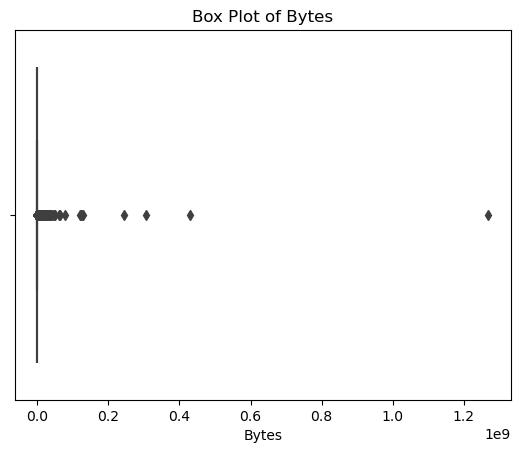

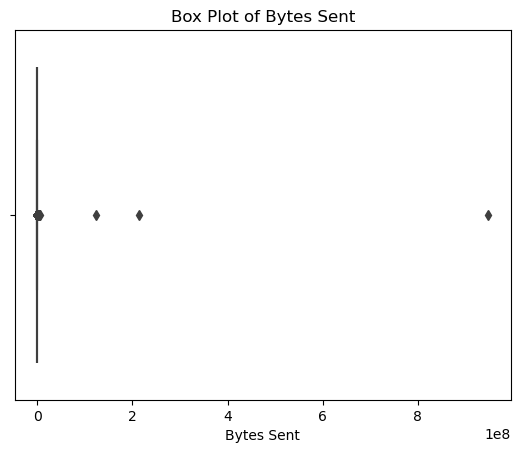

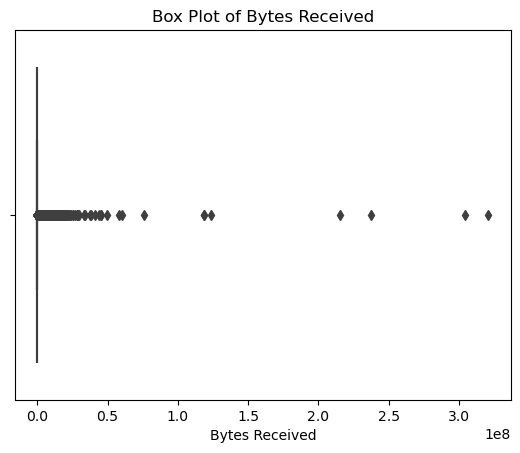

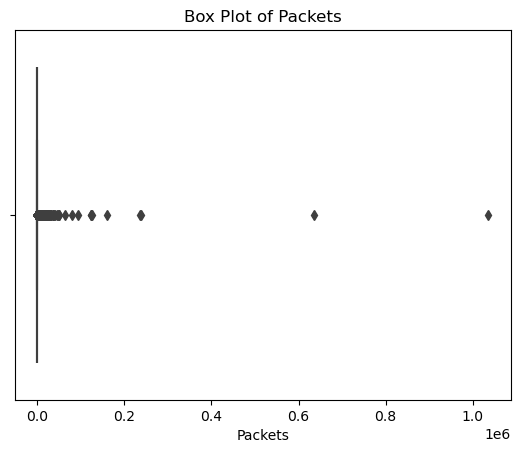

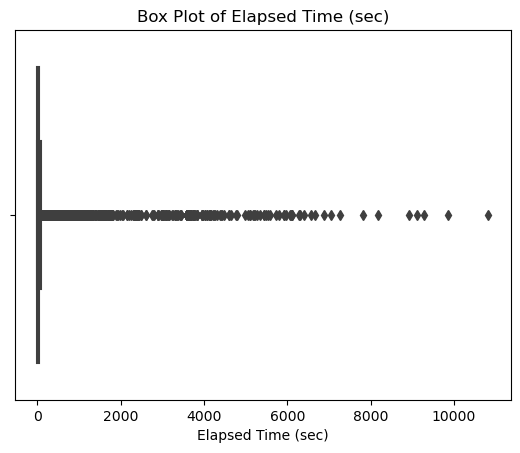

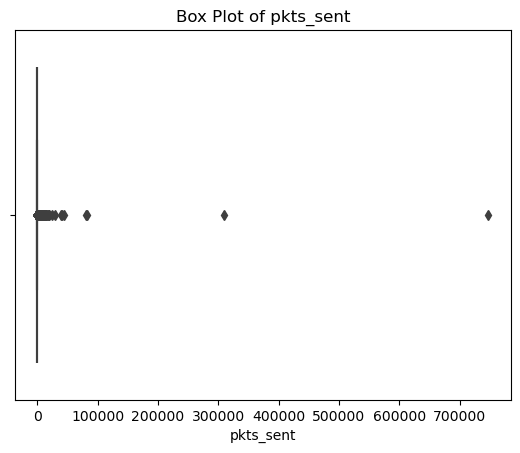

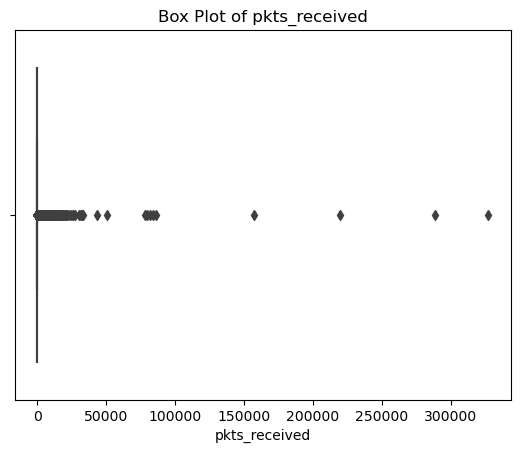

In [11]:
numerical_columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

for column in numerical_columns:
    sns.boxplot(x=column, data=df)
    plt.xlabel(column)
    plt.title(f'Box Plot of {column}')
    plt.show()

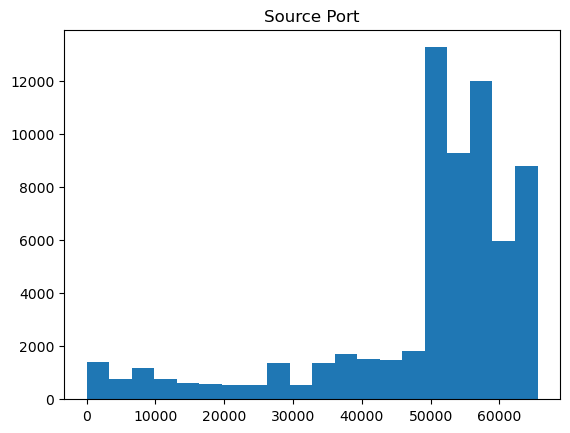

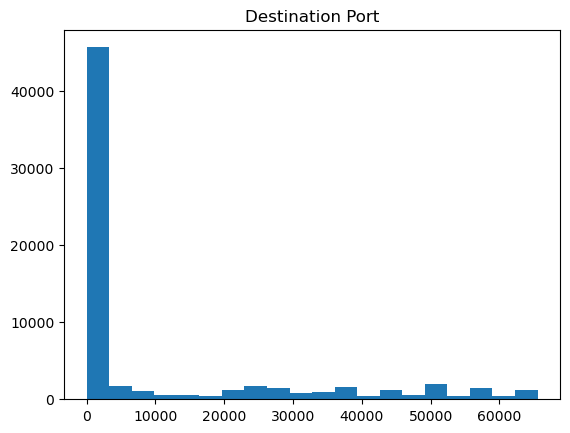

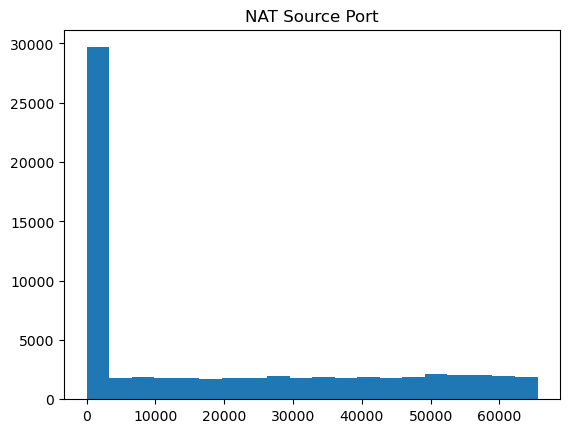

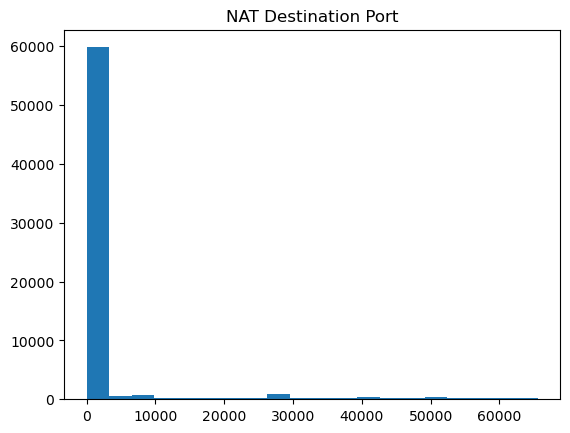

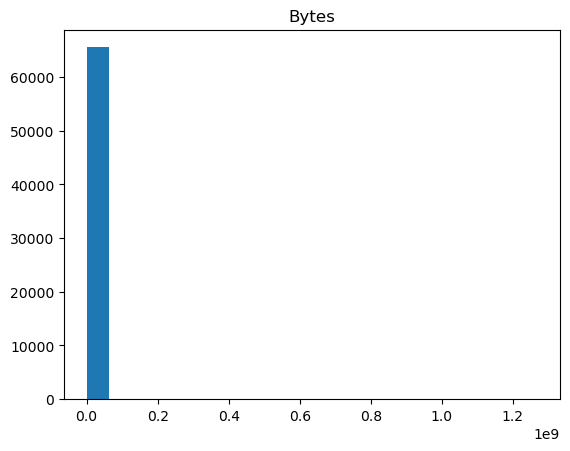

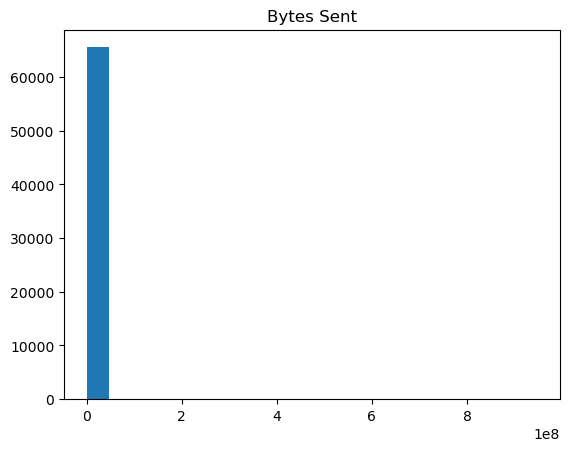

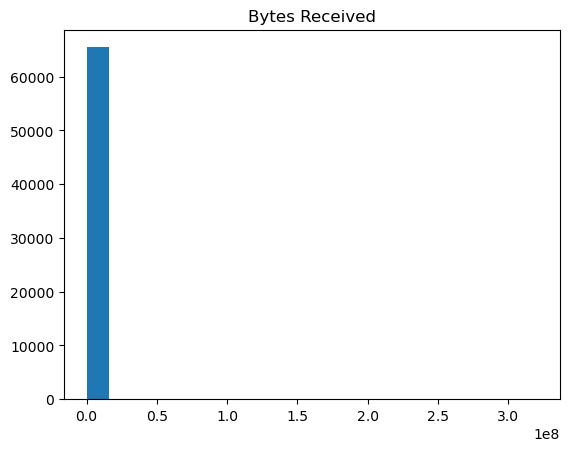

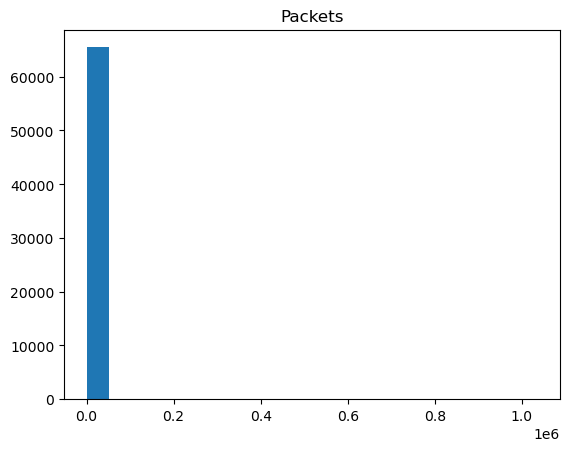

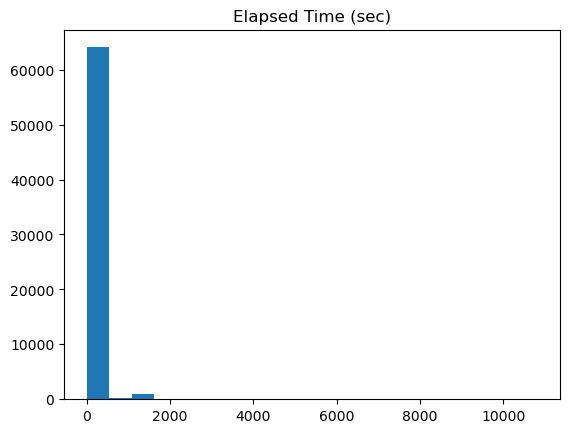

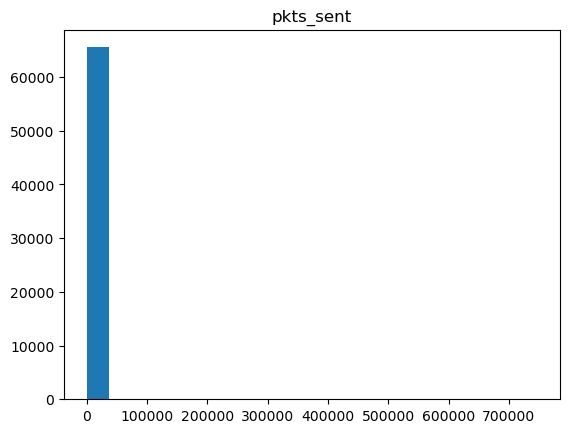

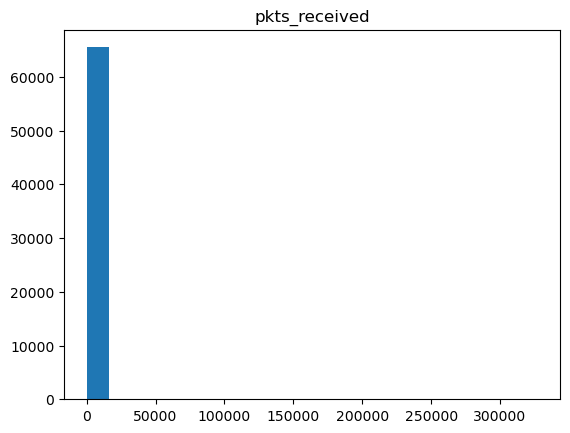

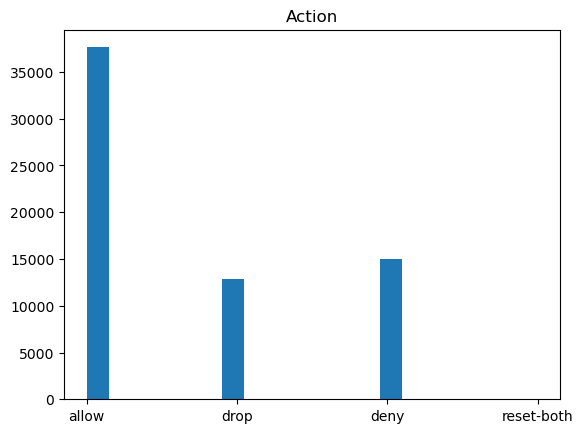

In [12]:
df = pd.DataFrame(df)

for column in df.columns:
    plt.hist(df[column], bins=20)
    plt.title(column)
    plt.show()

# Z-score or IQR for removing Outliers

Here we first select only numerical columns for the data cleaning. I had done beforehand a very slight removal of outliers just by visualisation of the data points onto the box plots, but decided to use the z-score standardisation. 

However, when I observed how skewed that data is, I changed my approach to IQR InterQuartile Range, that is said to be more appropriate to skewed distibutions. This approach would filter the data too much and basically remove 15k rows, which can be very bad in terms of data loss.

So even with the skewed data, the more conservative approach was the one chosen to taken care of the outliers. 

### Z-Score

In [13]:
numerical_cols = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

z_scores = stats.zscore(df[numerical_cols])
threshold = 3
outlier_rows = (np.abs(z_scores) < threshold).all(axis=1)
df_clean = df[outlier_rows]

print("Original shape:", df.shape)
print("Shape after removing outliers:", df_clean.shape)

Original shape: (65532, 12)
Shape after removing outliers: (64125, 12)


## Box plots of the df_clean dataset

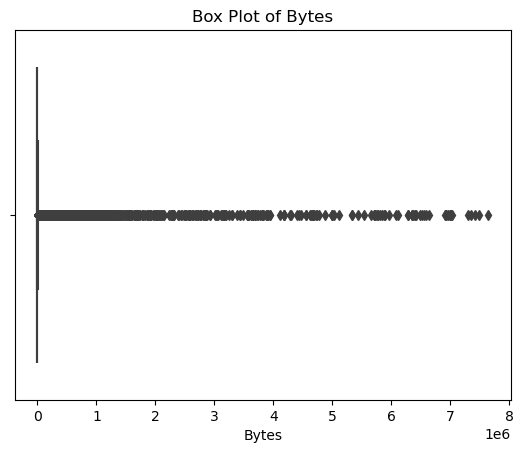

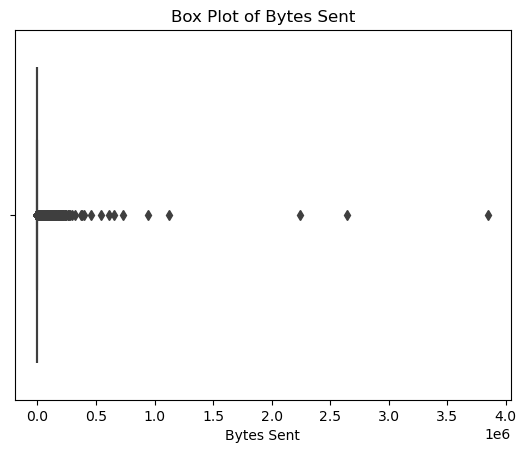

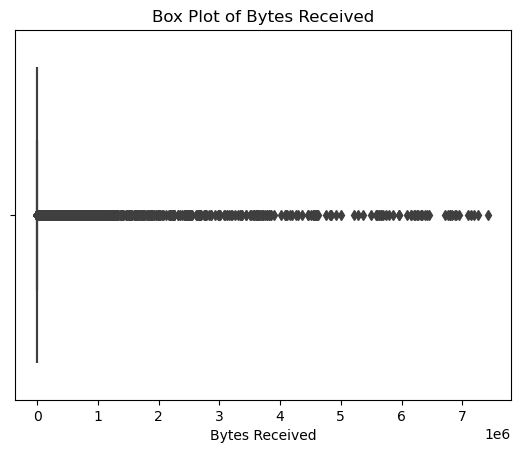

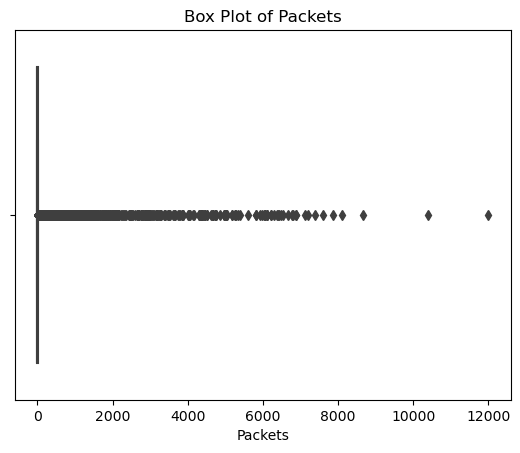

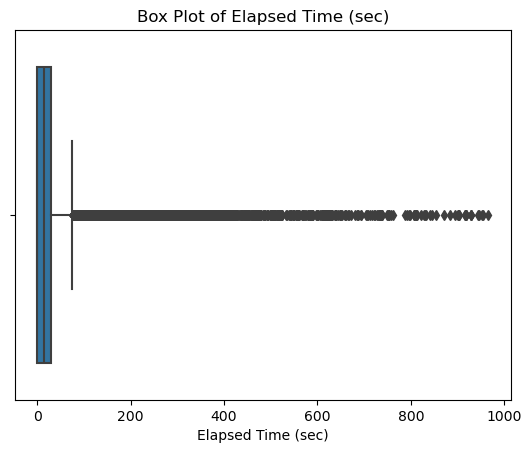

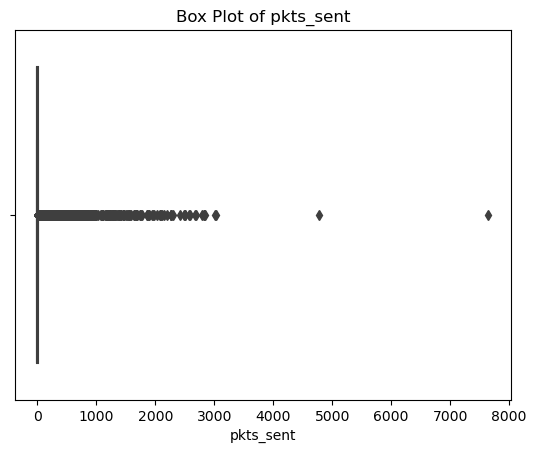

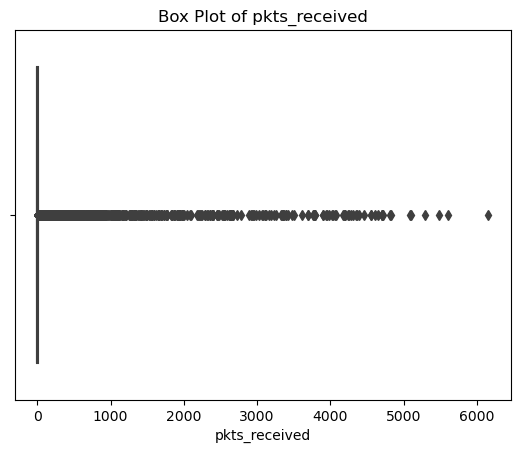

In [14]:
numerical_columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

for column in numerical_columns:
    sns.boxplot(x=column, data=df_clean)
    plt.xlabel(column)
    plt.title(f'Box Plot of {column}')
    plt.show()

In [15]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [16]:
df_clean.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,64125.000000,64125.000000,64125.000000,64125.000000,6.412500e+04,6.412500e+04,6.412500e+04,64125.000000,64125.000000,64125.000000,64125.000000
mean,49550.534690,10300.772507,18956.519407,2220.959595,2.167909e+04,1.647328e+03,2.003176e+04,28.015345,31.679423,11.160078,16.855267
std,15184.459776,18293.929241,21929.336431,8789.335595,2.384828e+05,2.358583e+04,2.310465e+05,246.098814,67.582683,88.819675,165.379159
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000
25%,49242.000000,53.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000
50%,53864.000000,445.000000,7882.000000,53.000000,1.680000e+02,8.800000e+01,7.400000e+01,2.000000,15.000000,1.000000,1.000000
75%,58638.000000,11392.000000,37799.000000,443.000000,7.330000e+02,1.920000e+02,4.170000e+02,5.000000,30.000000,3.000000,2.000000
max,65534.000000,65504.000000,65535.000000,65387.000000,7.644833e+06,3.850148e+06,7.429337e+06,11999.000000,966.000000,7647.000000,6155.000000


## Treating Bytes

We can see in the Boxplot below that there are 4 data points that are outliers and can affect our results, so we will drop all the values above a certain range (200 million bytes). This will prevent that the outlining values influence any of our predictions. We should do this with all the numerical columns

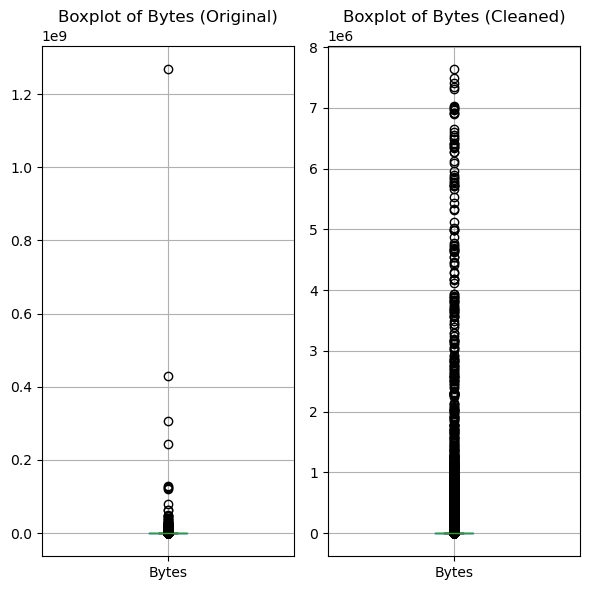

In [17]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Bytes')
plt.title('Boxplot of Bytes (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Bytes')
plt.title('Boxplot of Bytes (Cleaned)')

plt.tight_layout()
plt.show()

------------------------------------------

## Treating Bytes Sent

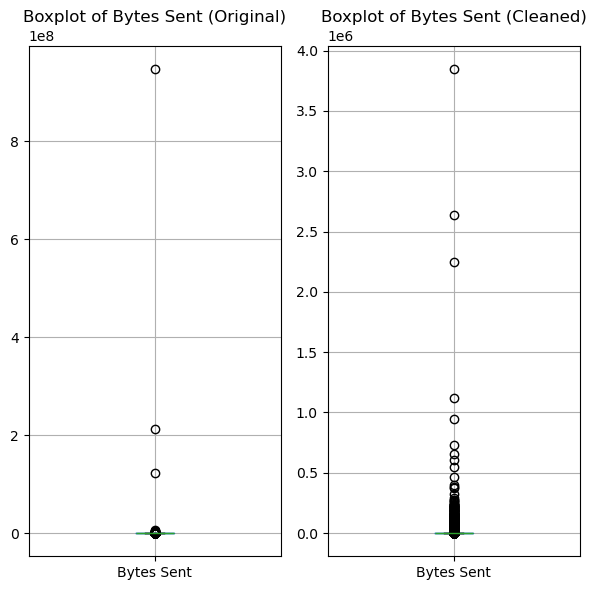

In [18]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Bytes Sent')
plt.title('Boxplot of Bytes Sent (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Bytes Sent')
plt.title('Boxplot of Bytes Sent (Cleaned)')

plt.tight_layout()
plt.show()

----------------

##  Treating Bytes Received

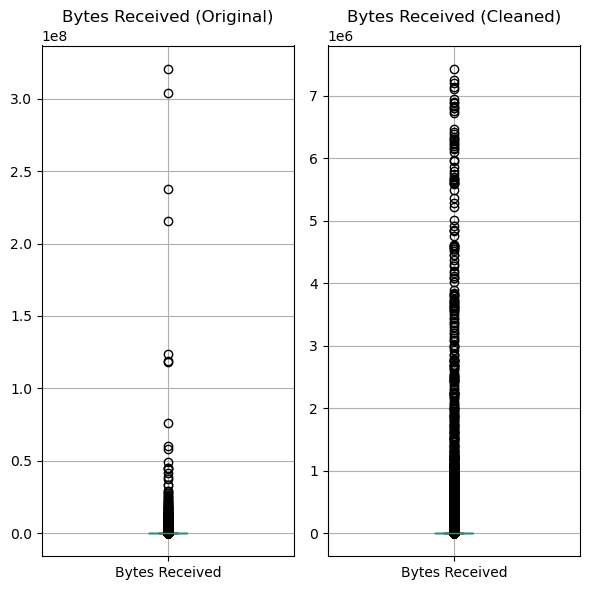

In [19]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Bytes Received')
plt.title('Bytes Received (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Bytes Received')
plt.title('Bytes Received (Cleaned)')

plt.tight_layout()
plt.show()

--------------------

## Treating Packets

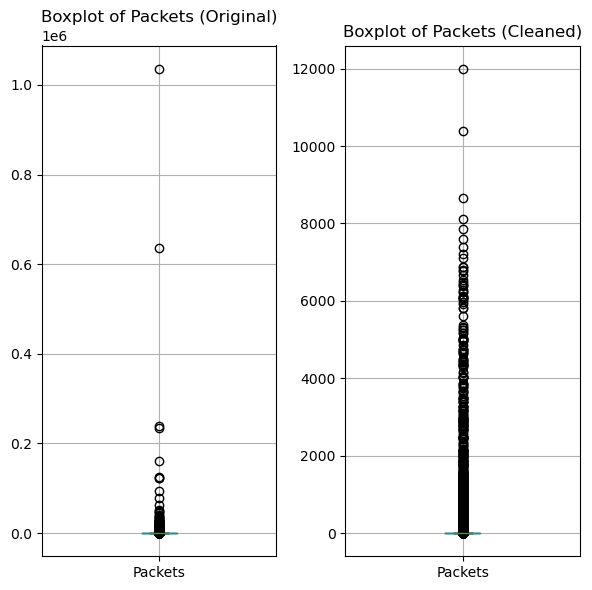

In [20]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Packets')
plt.title('Boxplot of Packets (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Packets')
plt.title('Boxplot of Packets (Cleaned)')

plt.tight_layout()
plt.show()

----------------

## Treating Elapsed Time (sec)

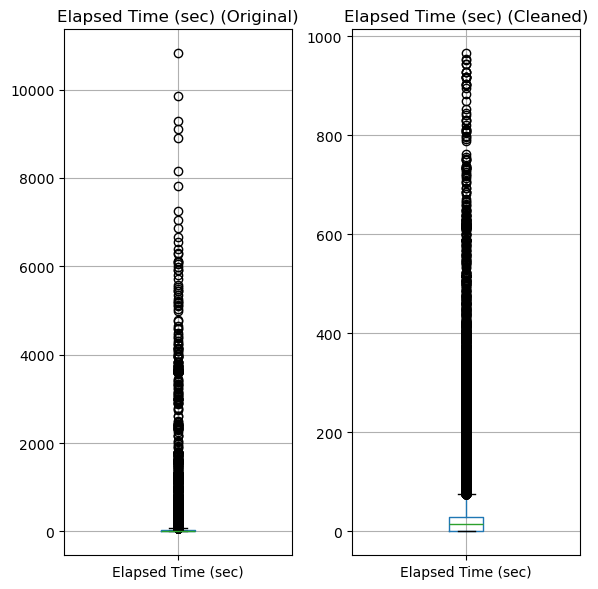

In [21]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='Elapsed Time (sec)')
plt.title('Elapsed Time (sec) (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='Elapsed Time (sec)')
plt.title('Elapsed Time (sec) (Cleaned)')

plt.tight_layout()
plt.show()

--------------

## Treating pkts_sent

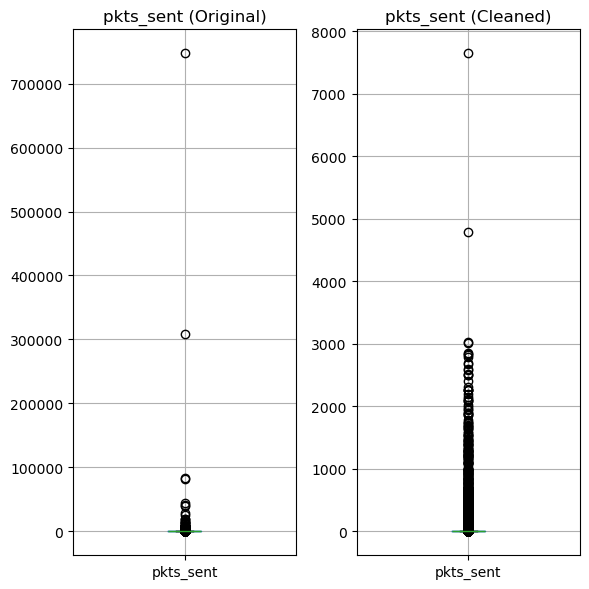

In [22]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='pkts_sent')
plt.title('pkts_sent (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='pkts_sent')
plt.title('pkts_sent (Cleaned)')

plt.tight_layout()
plt.show()

-----------

## Treating pkts_received

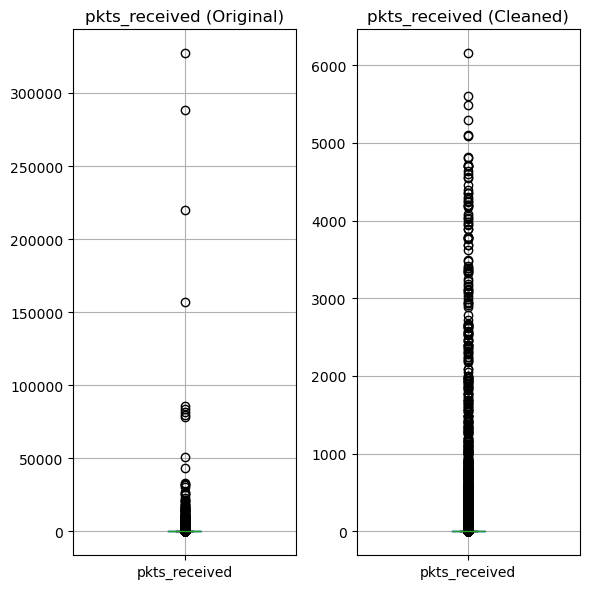

In [23]:
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
df.boxplot(column='pkts_received')
plt.title('pkts_received (Original)')

plt.subplot(1, 2, 2)
df_clean.boxplot(column='pkts_received')
plt.title('pkts_received (Cleaned)')

plt.tight_layout()
plt.show()

-----------

## EDA

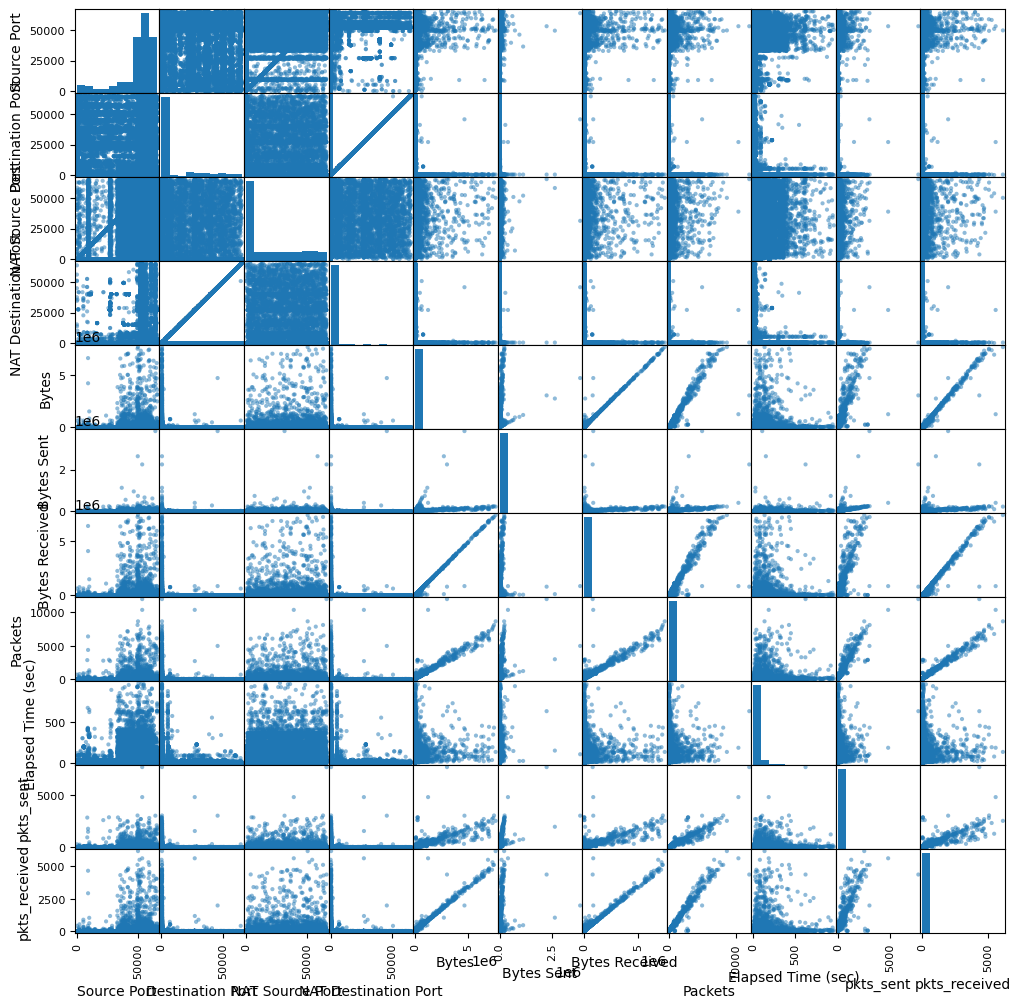

In [24]:
scatter_matrix(df_clean, figsize=(12, 12))
pyplot.show()

-------------

In [25]:
#RFE feature elimination method - this helps on selecting which features should be used for model building
# chi-square test which columns to use in the model

#Ideas of Algorithm
#RandomForest
#XGBoost
#KNN


## RFE

In [26]:
model = RandomForestClassifier()
X = df_clean.drop(columns=['Action'])
y = df_clean['Action']

rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Rank': rfe.ranking_})
print("Selected Features:")
print(selected_features[selected_features['Selected']])

Selected Features:
                Feature  Selected  Rank
1      Destination Port      True     1
2       NAT Source Port      True     1
3  NAT Destination Port      True     1
4                 Bytes      True     1
8    Elapsed Time (sec)      True     1


## Dummy Encoding of Action

We need to dummy the dataset to process Action on Models.

In [27]:
# Getting Dummies
df_encoded = pd.get_dummies(df_clean['Action'], prefix='Action')

#Concatting that with data_clean so we have the proper dataset
df_encoded = pd.concat([df_clean, df_encoded], axis=1)

# Dropping the object column
df_encoded.drop('Action', axis=1, inplace=True)

In [28]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


In [29]:
df.shape

(65532, 12)

## Random Forest

In [34]:
X = df_encoded[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]
y = df_encoded[['Action_allow', 'Action_deny', 'Action_drop', 'Action_reset-both']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

mse = np.mean(np.logical_xor(y_test, y_pred))
print("Loss of data:", mse)

y_test_values = y_test.values
y_pred_values = y_pred

mse_allow = np.mean(np.logical_xor(y_test_values[:, 0], y_pred_values[:, 0]))
mse_deny = np.mean(np.logical_xor(y_test_values[:, 1], y_pred_values[:, 1]))
mse_drop = np.mean(np.logical_xor(y_test_values[:, 2], y_pred_values[:, 2]))
mse_reset_both = np.mean(np.logical_xor(y_test_values[:, 3], y_pred_values[:, 3]))

print("MSE for Action_allow:", mse_allow)
print("MSE for Action_deny:", mse_deny)
print("MSE for Action_drop:", mse_drop)
print("MSE for Action_reset-both:", mse_reset_both)

Accuracy: 0.997972709551657
Loss of data: 0.00101364522417154
MSE for Action_allow: 0.00023391812865497077
MSE for Action_deny: 0.00202729044834308
MSE for Action_drop: 0.0010916179337231969
MSE for Action_reset-both: 0.0007017543859649122


## KNN

In [36]:
X = df_encoded[['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]
y = df_encoded[['Action_allow', 'Action_deny', 'Action_drop', 'Action_reset-both']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9940740740740741
